# Import das bibliotecas

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# Variáveis das métricas dos modelos

In [26]:
acc_lr = []
f1_lr = []
acc_dt = []
f1_dt = []
acc_rf = []
f1_rf = []

# Leitura dos dados

In [27]:
data_training = pd.read_csv('falencia-treinamento.csv', delimiter=';')
data_test = pd.read_csv('falencia-teste.csv', delimiter=';')
data_result = pd.read_csv('modelo-submissao.csv', delimiter=';')

# Expansão do conjunto de treinamento

In [28]:
data_training_copy = data_training.copy()
data_training_expanded = pd.concat([data_training, data_training_copy])

# Divisão do conjunto de dados

In [29]:
# Divisão do conjunto de dados falencia-treinamento em dados de treinamento e dados de teste. Divisão de 70% treinamento e 30% testes
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(data_training_expanded.drop('Resultado', axis=1), data_training_expanded['Resultado'], test_size=0.3, random_state=42)

# Técnica Smote

In [30]:
# Técnica SMOTE para aplicar o Oversampling (criação de cópias da classe minoritária para que as classes fiquem equilibradas)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_init, y_train_init)

# Seleção de Características

In [31]:
# # Seleciona as características mais importantes para o modelo usando o teste qui-quadrado
selector = SelectKBest(chi2, k=8)
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Regressão Logística

In [32]:
def logistic_regression(X_train, y_train, X_test, y_test):
    # Cria um modelo de regressão logística
    logistic_model = LogisticRegression(max_iter = 1000)
    
    # Ajusta o modelo aos dados de treinamento
    logistic_model.fit(X_train, y_train)
    
    # Faz previsões nos dados de teste
    y_pred_lr = logistic_model.predict(X_test)

    # Calcula a acurácia do modelo nos dados de teste extraído dos de treinamento
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    f_measure_lr = f1_score(y_test, y_pred_lr, average='weighted')
    
    return accuracy_lr, f_measure_lr

# Árvore de Decisão

In [33]:
def decision_tree(X_train, y_train, X_test, y_test):
    tree_model = DecisionTreeClassifier(min_samples_split=3)

    # Ajusta o modelo aos dados de treinamento
    tree_model.fit(X_train, y_train)

    # Faz previsões nos dados de teste
    y_pred_dt = tree_model.predict(X_test)

    # Calcula a acurácia e f-measure do modelo nos dados de teste
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    f_measure_dt = f1_score(y_test, y_pred_dt, average='weighted')
    
    return accuracy_dt, f_measure_dt

# Random Forest

In [34]:
def random_forest(X_train, y_train, X_test, y_test):
    # Cria um modelo de Random Forest com 100 árvores de decisão
    rf_model = RandomForestClassifier(n_estimators=100)

    # Ajusta o modelo aos dados de treinamento
    rf_model.fit(X_train, y_train)

    # Faz previsões nos dados de teste
    y_pred_rf = rf_model.predict(X_test)

    # Calcula a acurácia e f-measure do modelo nos dados de teste
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    f_measure_rf = f1_score(y_test, y_pred_rf, average='weighted')
    
    return accuracy_rf, f_measure_rf

# Validação Cruzada (RepeatedKFold)

In [35]:
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

accuracy_lr_list = []
f_measure_lr_list = []
accuracy_dt_list = []
f_measure_dt_list = []
accuracy_rf_list = []
f_measure_rf_list = []

for train_index, test_index in kf.split(X_train_selected):
    # Divide os dados entre treinamento e teste
    X_train, X_test = X_train_selected[train_index], X_train_selected[test_index]
    y_train, y_test = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]
    
    # Regressão Logística
    accuracy_lr, f_measure_lr = logistic_regression(X_train, y_train, X_test, y_test)
    
    # Árvore de Decisão
    accuracy_dt, f_measure_dt = decision_tree(X_train, y_train, X_test, y_test)
    
    # Random Forest
    accuracy_rf, f_measure_rf = random_forest(X_train, y_train, X_test, y_test)
    
    accuracy_lr_list.append(accuracy_lr)
    f_measure_lr_list.append(f_measure_lr)
    
    accuracy_dt_list.append(accuracy_dt)
    f_measure_dt_list.append(f_measure_dt)
    
    accuracy_rf_list.append(accuracy_rf)
    f_measure_rf_list.append(f_measure_rf)

# Avaliação dos modelos

Logistic Regression
Acurácia: 0.7093506493506492
F-Measure: 0.7091955642030864

Árvore de Decisão
Acurácia: 0.9062337662337663
F-Measure: 0.906214009955219

Random Forest
Acurácia: 0.9329870129870129
F-Measure: 0.9329080096334669


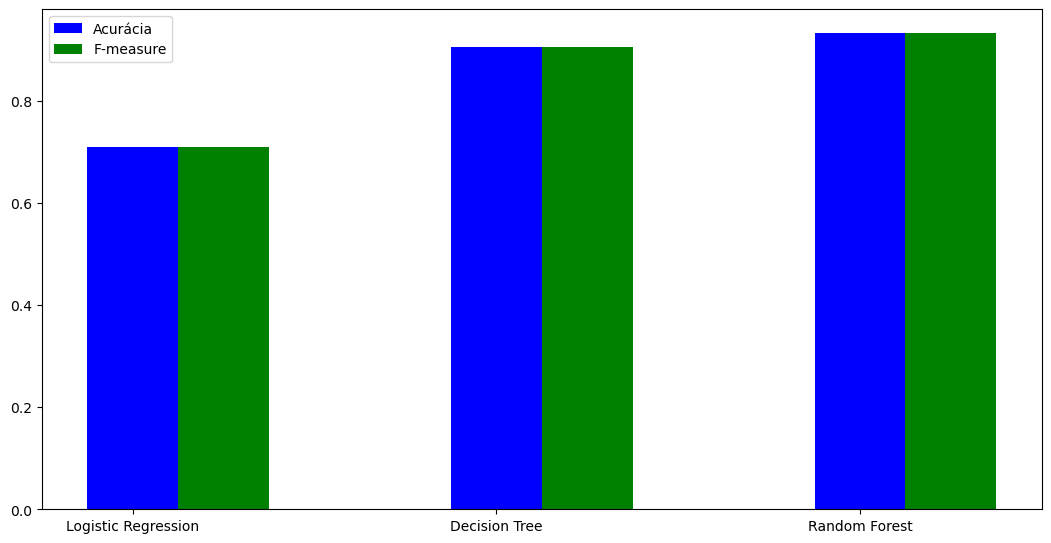

In [38]:
# Define as posições das barras
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
x_pos = np.arange(len(models))
x_pos = x_pos + 0.25

# Plota o gráfico
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(x_pos, [np.mean(accuracy_lr_list), np.mean(accuracy_dt_list), np.mean(accuracy_rf_list)], color='b', width=0.25)
ax.bar(x_pos + 0.25, [np.mean(f_measure_lr_list), np.mean(f_measure_dt_list), np.mean(f_measure_rf_list)], color='g', width=0.25)
ax.legend(['Acurácia', 'F-measure'])
ax.set_xticks(x_pos)
ax.set_xticklabels(models)

# Exibe os valores finais
print('Logistic Regression')
print(f'Acurácia: {np.mean(accuracy_lr_list)}')
print(f'F-Measure: {np.mean(f_measure_lr_list)}')
print('\nÁrvore de Decisão')
print(f'Acurácia: {np.mean(accuracy_dt_list)}')
print(f'F-Measure: {np.mean(f_measure_dt_list)}')
print('\nRandom Forest')
print(f'Acurácia: {np.mean(accuracy_rf_list)}')
print(f'F-Measure: {np.mean(f_measure_rf_list)}')
plt.show()